# AUTHOR
***Written by Ho Sy The***

Hanoi University of Science and Technology

IT1 04 - K65.

*Github: https://github.com/hsthe29*

- **date: 2022-05-20**

# SUMMARY

## Loss function of Multi-class SVM:
$~~~~\mathcal{L}(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) + \frac{\lambda}{2} ||\mathbf{W}||_F^2~~~~$

- Explain symbols:
 - $\mathbf{x}_n$ is extended data point
 - C is number of classes
 - $\mathbf{x}_n \in \mathbf{R}^d → \mathbf{X} \in  \mathbf{R}^{d×N}$
 - $\mathbf{W} \in \mathbf{R}^{d×C}$

## Gradient of loss function (Temporarily ignore the multiplier $\frac{1}{N}$):
$\begin{eqnarray}
\frac{\partial }{\partial \mathbf{w}_{y_n}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& 
\left\{
\begin{matrix}
0 & \text{if}& 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n < 0 \ 
-\mathbf{x}_n & \text{if} &1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n > 0
\end{matrix}
\right. && ~~~~\\
\frac{\partial }{\partial \mathbf{w}_{j}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& 
\left\{
\begin{matrix}
0 & \text{if}& 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n < 0 \ 
\mathbf{x}_n & \text{if} &1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n > 0
\end{matrix}
\right. && ~~~~ \\
\frac{\partial }{\partial \mathbf{w}_{y_n}}\max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) &=& λ\mathbf{W} \\
⇒~~\frac{\partial }{\partial \mathbf{w}} \mathcal{L} &=& \big [\frac{\partial }{\partial \mathbf{w}_1}, \frac{\partial }{\partial \mathbf{w}_2}, \dots, \frac{\partial }{\partial \mathbf{w}_C}\big]
\end{eqnarray}$

## Update rule
- $\mathbf{W}_{t+1} = \mathbf{W}_t - η\frac{\partial }{\partial \mathbf{w}} \mathcal{L}$

## Compute the predicted output

$\hat{y}_n = \arg\max\mathbf{W}^T\mathbf{x}_n$

**I implement Multi-class SVM with Mini-batch Gradient Descent**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score


In [5]:
# check gradient
# fake data
Cf = 4
Nf = 10
df = 3
Xf = np.random.rand(df, Nf) # [d, N]
Wf = np.random.rand(df, Cf) # [d, C]

lf = 1e-2

yf = np.array([0, 1, 2, 3, 2, 1, 3, 0, 1, 2]) # [1, N]


def cost(w):
  Zf = w.T @ Xf # [C, d] x [d, N] = [C, n]
  correct_class = np.choose(yf, Zf)
  reg = .1

  hinge = np.maximum(0, Zf - correct_class + 1)
  hinge[yf, range(10)] = 0
  # print(hinge)
  loss = np.sum(hinge) / 10  + 0.5 * reg * np.sum(w * w)
  hinge[hinge > 0] = 1
  hinge[yf, range(10)] = -np.sum(hinge, axis=0)

  dw = Xf @ hinge.T / 10 + reg * w
  return loss, dw

def grad(w):
  Zf = w.T @ Xf # [C, d] x [d, N] = [C, n]
  correct_class = np.choose(yf, Zf)

  hinge = np.maximum(0, Zf - correct_class + 1)
  hinge[yf, range(10)] = 0
  hinge[hinge > 0] = 1
  hinge[yf, range(10)] = -np.sum(hinge, axis=0)

  dw = Xf @ hinge.T
  # print(hinge)
  return dw

def num_grad(w):
  eps = 1e-6
  fw = w.flatten()
  g = np.zeros_like(fw)
  for i in range(w.size):
    wp = fw.copy()
    wn = fw.copy()
    wp[i] += eps
    wn[i] -= eps
    g[i] = (cost(wp.reshape(w.shape))[0] - cost(wn.reshape(w.shape))[0]) / (2 * eps)

  return g.reshape(w.shape)

g1 = cost(Wf)[1]

g2 = num_grad(Wf)

print(g1)
print(g2)
print('Gradient different: ', np.linalg.norm(g1 - g2))


[[ 0.12783819 -0.17304447 -0.18591712  0.4296834 ]
 [ 0.29815938 -0.01968104 -0.06070845 -0.02193976]
 [ 0.05387294 -0.09621101  0.00922596  0.1325238 ]]
[[ 0.12783819 -0.17304447 -0.18591712  0.4296834 ]
 [ 0.29815938 -0.01968104 -0.06070846 -0.02193976]
 [ 0.05387294 -0.09621101  0.00922596  0.1325238 ]]
Gradient different:  9.693994547769223e-10


In [43]:
class MultiSVM:

  def __init__(self, n_classes=2, reg=.1, delta_=1, learning_rate=1e-3):
    self.n_classes_ = n_classes
    self.__reg = reg
    self.delta_ = delta_
    self.lr_ = learning_rate
    self.__reset()

  def __reset(self):
    self.w_ = None
    self.loss_ = None

  def __loss_function(self, X, y):
    if self.w_ is None:
      raise ValueError('MultiSVM has not been fitted yet!')
    Z = self.w_.T @ X # [C, d] x [d, N] = [C, n]
    correct_class = np.choose(y, Z)

    hinge = np.maximum(0, Z - correct_class + self.delta_)
    hinge[y, range(X.shape[1])] = 0

    loss =  np.sum(hinge) / X.shape[1] + 0.5 * self.__reg * np.sum(self.w_ * self.w_)
    hinge[hinge > 0] = 1
    hinge[y, range(X.shape[1])] = -np.sum(hinge, axis=0)

    dw = X @ hinge.T / X.shape[1] + self.__reg * self.w_
    return loss, dw

  def fit(self, X, y, batch_size=0, epochs=1001, show_result=False):
    self.__reset()
    if batch_size == 0:
      batch_size = X.shape[1]
    else:
      if X.shape[1] % batch_size != 0:
        raise ValueError('number of data points must be divisible by batch_size!')
    self.X = X
    self.y = y
    self.w_ = np.random.randn(X.shape[0], self.n_classes_)
    loss_ = list()
    check_ep = 100
    iter_per_epoch = X.shape[1] // batch_size
    
    for ep in range(epochs):
      mix_id = np.random.permutation(X.shape[1])
      # mix_id = np.arange(X.shape[1])
      for i in range(iter_per_epoch):
        id = mix_id[range(i * batch_size, (i + 1) * batch_size)]
        Xt = X[:, id]
        yt = y[id]

        _, dw = self.__loss_function(Xt, yt)

        self.w_ -= self.lr_ * dw
      # start  
      # loss, dw = self.__loss_function(X)

      # self.w_ -= self.lr_ * dw
      # loss_.append(loss)
      loss, _ = self.__loss_function(X, y)
      loss_.append(loss)
      
      if show_result and (ep % check_ep == 0):
        print('- epochs: {ep:7d},\tloss: {loss:-15.10f}'.format(ep = ep + 1, loss = loss))

    self.loss_ = np.array([loss_]).T
    if show_result:
      print('Histogram of Loss value:')
      plt.plot(self.loss_)
      plt.show()


  def decision_function(self, X):
    return self.w_.T @ X # [C, N]

  def predict(self, X):
    return np.argmax(self.decision_function(X), axis=0)

  def score(self, y_out, y = None):
    if y is None:
      y = self.y
    
    print(f'accuracy rate: {accuracy_score(y, y_out) * 100}%')

  def visualize(self, x_axis, y_axis, n_=500, level_sets=200, dpi=100):
    plt.figure(dpi=dpi)

    x_ = np.linspace(x_axis[0], x_axis[1], n_)
    y_ = np.linspace(y_axis[0], y_axis[1], n_)

    x_, y_ = np.meshgrid(x_, y_)

    xx = x_.reshape(-1)
    yy = y_.reshape(-1)
    x = np.vstack((xx, yy, np.ones((1, n_ * n_))))
    z = self.predict(x)
    z = z.reshape(n_, n_)

    plt.contourf(x_, y_, z, level_sets, cmap='jet', alpha = .3)

    plt.scatter(self.X[0], self.X[1], s=50, c=self.y) #, markeredgecolor='k')

    plt.scatter(self.X[0], self.X[1], s=50,
                   linewidth=1, marker='o', facecolors='none', edgecolors='k')
      
    plt.axis('tight')
    plt.title(f'accuracy rate: {accuracy_score(self.y, self.predict(self.X)) * 100}%')

    plt.show()

  def __str__(self):
    return f'''
    class name <MultiSVM>
    params: - n_classes = {self.n_classes_}
            - reg = {self.__reg}
            - delta_ = {self.delta_}
            - learning_rate = {self.lr_}
    '''

In [7]:
means = [[1, 1],
         [1, 4],
         [4, 1],
         [4, 4]]

cov = [[.8, .2],
       [.2, .8]]

N = 100

X0 = np.random.multivariate_normal(means[0], cov, N).T
X1 = np.random.multivariate_normal(means[1], cov, N).T
X2 = np.random.multivariate_normal(means[2], cov, N).T
X3 = np.random.multivariate_normal(means[3], cov, N).T

(3, 400)


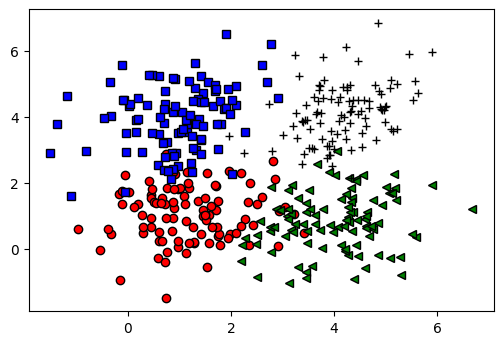

In [8]:
X_temp = np.hstack((X0, X1, X2, X3))
X = np.vstack((X_temp, np.ones((1, 4*N))))

y = np.array([0] * N + [1] * N + [2] * N + [3] * N)
print(X.shape)

plt.figure(dpi=100)

plt.plot(X0[0], X0[1], 'ro', markeredgecolor='k')
plt.plot(X1[0], X1[1], 'bs', markeredgecolor='k')
plt.plot(X2[0], X2[1], 'g<', markeredgecolor='k')
plt.plot(X3[0], X3[1], 'm+', markeredgecolor='k')


plt.show()


- epochs:       1,	loss:    9.4838928163
- epochs:     101,	loss:    7.3046171224
- epochs:     201,	loss:    5.4661391302
- epochs:     301,	loss:    3.9495355225
- epochs:     401,	loss:    2.9869770578
- epochs:     501,	loss:    2.5912620285
- epochs:     601,	loss:    2.3234948609
- epochs:     701,	loss:    2.0969137623
- epochs:     801,	loss:    1.9015547676
- epochs:     901,	loss:    1.7370802001
- epochs:    1001,	loss:    1.5927797051
- epochs:    1101,	loss:    1.4606853343
- epochs:    1201,	loss:    1.3399721382
- epochs:    1301,	loss:    1.2304118345
- epochs:    1401,	loss:    1.1312498045
- epochs:    1501,	loss:    1.0463491953
- epochs:    1601,	loss:    0.9771956944
- epochs:    1701,	loss:    0.9243807716
- epochs:    1801,	loss:    0.8845594793
- epochs:    1901,	loss:    0.8532632995
- epochs:    2001,	loss:    0.8313539274
- epochs:    2101,	loss:    0.8145292836
- epochs:    2201,	loss:    0.8004113799
- epochs:    2301,	loss:    0.7883109057
- epochs:    240

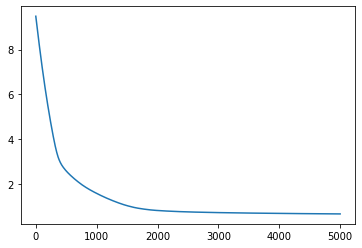

In [40]:
svm = MultiSVM(n_classes=4, learning_rate=1e-3)
svm.fit(X, y, epochs=5001, show_result=True)

In [41]:
y_pred = svm.predict(X)
print(y_pred)
svm.score(y_pred)

[0 0 0 2 1 0 0 2 2 0 0 0 1 0 0 3 0 0 0 2 0 0 2 2 1 0 0 2 0 0 2 0 0 0 0 2 0
 0 0 0 0 0 2 1 0 0 0 2 3 2 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 2 2 0 0 0 0 2 0 0
 0 0 2 2 0 0 2 2 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
accuracy rate: 90.0%


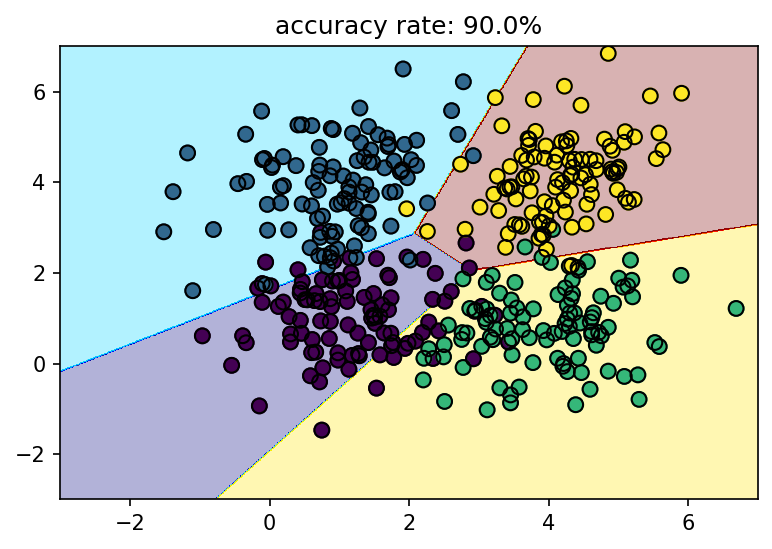

In [42]:
svm.visualize([-3, 7], [-3, 7], dpi=150)

# As for the CIFAR-10 dataset, I won't use it here (but i ran it on my laptop).

# Deep Neural Network using Multi-class Support Vector Machine classifier

*Note: One hidden layer DNN*

## SUMMARY
- Diagram of neural network:

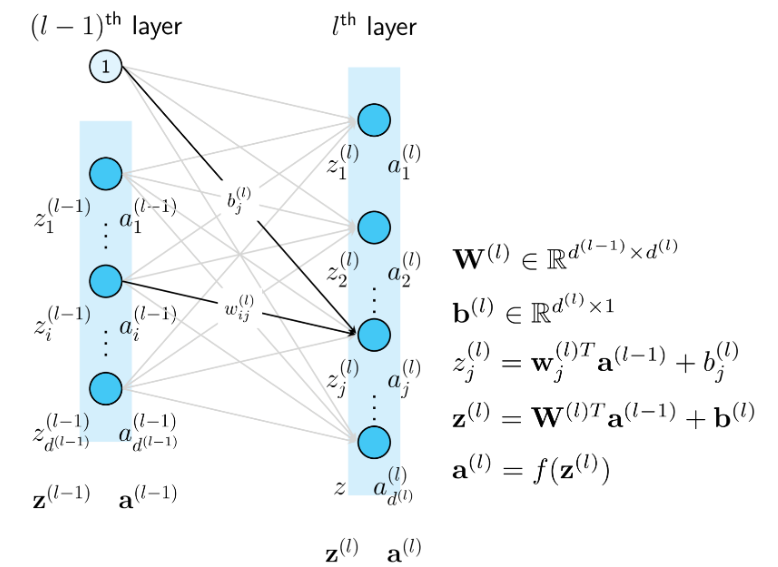

## With each coefficient $w_{ij}^{(l)}, b_{i}^{(l)}$
### Feedforward

- Activation function $f$ is ReLU: $\text{ReLU}(z) = \max(0, z)$
- Feedforward equation:

$\begin{eqnarray}
\mathbf{a}^{(0)} &=& \mathbf{x} \\ 
z_{i}^{(l)} &=& \mathbf{w}_i^{(l)T}\mathbf{a}^{(l-1)} + b_i^{(l)} \\ 
\mathbf{z}^{(l)}  &=& \mathbf{W}^{(l)T}\mathbf{a}^{(l-1)} + \mathbf{b}^{(l)},~~ l =  1, 2, \dots, L \\
\mathbf{a}^{(l)} &=& f(\mathbf{z}^{(l)}), ~~ l =  1, 2, \dots, L \\
\mathbf{\hat{y}} &=& \mathbf{a}^{(L)}
\end{eqnarray}$

### Backpropagation

1. Feedforward: For each input data point $\mathbf{x}$, compute corresponding output of network. During the computation, save the activation $\mathbf{a}^{(l)}$ at each layer.

2. With each unit $j$ at output layer, calculate:  $e_j^{(L)} = \frac{\partial J}{\partial z_j^{(L)}}$
 - $~J(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - \mathbf{w}_{y_n}^T \mathbf{x}_n + \mathbf{w}_j^T\mathbf{x}_n) + \frac{\lambda}{2} ||\mathbf{W}||_F^2~~~~$
 - $~e_j^{(L)} = \frac{\partial J}{\partial z_j^{(L)}} = \frac{\partial J}{\partial w_j^{(L)}}\frac{\partial w_j^{(L)}}{\partial z_j^{(L)}}$

3. For $l = L-1, L-2, …, 1$ calculate:  $e_j^{(l)} = \left( \mathbf{w}_{j:}^{(l+1)} \mathbf{e}^{(l+1)} \right) f’(z_j^{(l)})$

4. Update gradient of each coefficient:  $\begin{eqnarray}
\frac{\partial J}{\partial w_{ij}^{(l)}} &=& a_i^{(l-1)} e_j^{(l)} \ 
\frac{\partial J}{\partial b_{j}^{(l)}} &=& e_j^{(l)}
\end{eqnarray}$

## Gradient with matrix $\mathbf{W}^{(l)},~\mathbf{b}^{(l)}$
### Feedforward
$~~~~~~~~~~\begin{eqnarray}
\mathbf{A}^{(0)} &=& \mathbf{X} \\
\mathbf{Z}^{(1)} &=& \mathbf{W}^{(1)T}\mathbf{X} \\
\mathbf{A}^{(1)} &=& \max(\mathbf{Z}^{(1)}, \mathbf{0}) \\
\mathbf{Z}^{(2)} &=& \mathbf{W}^{(2)T}\mathbf{A}^{(1)} \\
\mathbf{\hat{Y}} &=& \mathbf{A}^{(2)} = \text{Multi-classSVM}(\mathbf{Z}^{(2)})
\end{eqnarray}$
### Backpropagation
$~~~~~\begin{eqnarray}
\mathbf{E}^{(2)} &=& \frac{\partial J}{\partial \mathbf{Z}^{(2)}} \\ 
\frac{\partial J}{\partial \mathbf{W}^{(2)}} &=& \mathbf{A}^{(1)}  \mathbf{E}^{(2)T} \\ 
\frac{\partial J}{\partial \mathbf{b}^{(2)}} &=& \sum_{n=1}^N\mathbf{e}_n^{(2)} \\ 
\mathbf{E}^{(1)} &=& \left(\mathbf{W}^{(2)}\mathbf{E}^{(2)}\right) \odot f’(\mathbf{Z}^{(1)}) \\ 
\frac{\partial J}{\partial \mathbf{W}^{(1)}} &=& \mathbf{A}^{(0)}  \mathbf{E}^{(1)T} = \mathbf{X}\mathbf{E}^{(1)T}\\ 
\frac{\partial J}{\partial \mathbf{b}^{(1)}} &=& \sum_{n=1}^N\mathbf{e}_n^{(1)} \\ 
\end{eqnarray}$

- **Find $\mathbf{E}^{(2)} = \frac{\partial J}{\partial \mathbf{Z}^{(2)}}$:**

$J(\mathbf{X}, \mathbf{y}, \mathbf{W}) = \frac{1}{N}\sum_{n=1}^N \sum_{j \neq y_n} \max(0, 1 - (\mathbf{w}_{y_n}^T \mathbf{x}_n + b_{y_n}) + (\mathbf{w}_j^T\mathbf{x}_n + b_j)) + \frac{\lambda}{2} ||\mathbf{W}||_F^2$
- We consider a data point $\mathbf{x}_i$ and let $z_{ji} = \mathbf{w}_j^T\mathbf{x}_i + b_j$. Here, we temporarily ignore the regularization loss part and coeff $\frac{1}{N}$:

$\begin{eqnarray}
J_i(\mathbf{X}_i, \mathbf{y}_i, \mathbf{W}) &=& \sum_{j \neq y_i} \max(0, 1 - (\mathbf{w}_{y_i}^T \mathbf{x}_i+ b_{y_i}) + (\mathbf{w}_j^T\mathbf{x}_i+b_j))\\
&=& \sum_{j \neq y_i} \max(0, 1 - z_{y_ii} + z_{ji})\\
\end{eqnarray}$

$\begin{eqnarray}
⇒ \frac{∂J_i(\mathbf{W})}{∂z_{ji}} &=& 1 ~~\text{if} ~~1 - z_{y_ii} + z_{ji} > 0\\
\frac{∂J_i(\mathbf{W})}{∂z_{y_ii}} &=& -1 ~~\text{if} ~~1 - z_{y_ii} + z_{ji} > 0\\
\text{else} &=& 0
\end{eqnarray}$

$⇒ \frac{∂J(\mathbf{W})}{∂\mathbf{Z}} = λ\mathbf{W}^T\mathbf{X}^{\dagger}$

- Remember to multiply by $\frac{1}{N}$.

## Implementation

In [239]:
class DNN_SVM:
  def __init__(self, n_classes, units, learning_rate=1e-3, reg=0., delta=1):
    if len(units) != 3:
      raise ValueError('Illegal Argument Exception')
    if units[2] != n_classes:
      raise ValueError('Illegal Argument Exception')
    if min(units) < 2:
      raise ValueError('Invalid number of units in a layer!')
    if max(units) > 500:
      raise ValueError('Number of units in a layer is too large!')
      
    self.n_classes_ = n_classes
    self.units_ = units
    self.__lr = learning_rate
    self.__reg = reg
    self.__delta = delta
    self.loss_ = []  

  def __init_coeff_matrix(self):
    self.__h = self.units_[1]
    self.__W1 = 0.1*np.random.randn(self.units_[0], self.units_[1])
    self.__b1 = np.zeros((self.units_[1], 1))
    self.__W2 = 0.1*np.random.randn(self.units_[1], self.units_[2])
    self.__b2 = np.zeros((self.units_[2], 1))

  def __loss_function(self, X, y):
    if self.__W2 is None:
      raise ValueError('MultiSVM has not been fitted yet!')
    Z = self.__W2.T @ X + self.__b2# [C, d] x [d, N] = [C, n]
    correct_class = np.choose(y, Z)

    hinge = np.maximum(0, Z - correct_class + self.__delta)
    hinge[y, range(X.shape[1])] = 0

    loss =  np.sum(hinge) / X.shape[1] + 0.5 * self.__reg * np.sum(self.__W2 * self.__W2)
    hinge[hinge > 0] = 1
    hinge[y, range(X.shape[1])] = -np.sum(hinge, axis=0)

    dw = X @ hinge.T / X.shape[1] + self.__reg * self.__W2
    #    [C, n]           +                [C, d1] x [d1, n]
    E2 = hinge / X.shape[1] + self.__reg * self.__W2.T @ np.linalg.pinv(X).T
    return loss, dw, E2
  
  def fit(self, X, y, batch_size=0, epochs=1001, show_result=False):
    if self.units_[0] != X.shape[0]:
      raise ValueError('Illegal Argument Exception')
    if batch_size == 0:
      batch_size = X.shape[1]
    else:
      if X.shape[1] % batch_size != 0:
        raise ValueError('number of data points must be divisible by batch_size!')
    self.__init_coeff_matrix()
    self.X = X
    self.y = y
    check_ep = 100
    iter_per_epoch = X.shape[1] // batch_size
    self.loss_ = []
    
    # mini-batch gradient descent
    for ep in range(epochs):
      mix_id = np.random.permutation(X.shape[1])
      for j in range(iter_per_epoch):
        id = mix_id[range(j * batch_size, batch_size * (j + 1))]
        yt = y[id]
        Xt = X[:, id]
        # Feedforward
        Z1 = self.__W1.T @ Xt + self.__b1 # [d1, d0] x [do, n] = [d1, n]
        A1 = np.maximum(Z1, 0) # ReLU(Z) - Activation function
        Z2 = self.__W2.T @ A1 + self.__b2 # [d2, d1] x [d1, n] = [d2, n]

        # Backpropagation
        loss, dW2, E2 = self.__loss_function(A1, yt)
        db2 = np.sum(E2, axis=1, keepdims=True)
        E1 = self.__W2 @ E2 # [d1, n]
        E1[Z1 <= 0] = 0
        dW1 = Xt @ E1.T # [d0, n] x [n, d1]
        db1 = np.sum(E1, axis=1, keepdims=True)

        self.__W1 -= self.__lr * dW1
        self.__b1 -= self.__lr * db1
        self.__W2 -= self.__lr * dW2
        self.__b2 -= self.__lr * db2
      self.loss_.append(loss)
      if show_result and (ep % check_ep == 0):
        print('- epochs: {ep:7d},\tloss: {loss:-15.10f}'.format(ep = ep + 1, loss = loss))

    self.loss_ = np.array([self.loss_]).T
    if show_result:
      print('Histogram of Loss value:')
      plt.figure(figsize=(18, 6))
      plt.plot(self.loss_)
      plt.show()
    
  def decision_function(self, X):
    # duplicate code
    Z1 = self.__W1.T @ X + self.__b1 # [d1, d0] x [do, n] = [d1, n]
    A1 = np.maximum(Z1, 0) # ReLU(Z) - Activation function
    return self.__W2.T @ A1 + self.__b2 # [d2, d1] x [d1, n] = [d2, n]

  def predict(self, X):
    return np.argmax(self.decision_function(X), axis=0)

  def score(self, y1, y2 = None):
    if y2 is None:
      y2 = self.y
    
    print(f'accuracy rate: {accuracy_score(y1, y2) * 100}%')

  def visualize(self, x_axis, y_axis, n_=500, level_sets=200, dpi=100):
    plt.figure(dpi=dpi)

    x_ = np.linspace(x_axis[0], x_axis[1], n_)
    y_ = np.linspace(y_axis[0], y_axis[1], n_)

    x_, y_ = np.meshgrid(x_, y_)

    xx = x_.reshape(-1)
    yy = y_.reshape(-1)
    x = np.vstack((xx, yy))
    z = self.predict(x)
    z = z.reshape(n_, n_)

    plt.contourf(x_, y_, z, level_sets, cmap='jet', alpha = .3)

    plt.scatter(self.X[0], self.X[1], s=50, c=self.y) #, markeredgecolor='k')

    plt.scatter(self.X[0], self.X[1], s=50,
                   linewidth=1, marker='o', facecolors='none', edgecolors='k')
      
    plt.axis('tight')
    plt.title(f'accuracy rate of DNN: {accuracy_score(self.y, self.predict(self.X)) * 100}%')

    plt.show()

(2, 400)


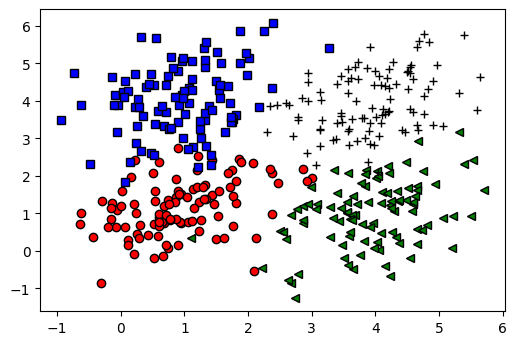

In [242]:
means2 = [[1, 1],
         [1, 4],
         [4, 1],
         [4, 4]]

cov2 = [[.6, .2],
       [.2, .6]]

N2 = 100

X0_ = np.random.multivariate_normal(means2[0], cov2, N2).T
X1_ = np.random.multivariate_normal(means2[1], cov2, N2).T
X2_ = np.random.multivariate_normal(means2[2], cov2, N2).T
X3_ = np.random.multivariate_normal(means2[3], cov2, N2).T

X_train_2 = np.hstack((X0_, X1_, X2_, X3_))
print(X_train_2.shape)

y_train_2 = np.array([0] * N2 + [1] * N2 + [2] * N2 + [3] * N2)

plt.figure(dpi=100)

plt.plot(X0_[0], X0_[1], 'ro', markeredgecolor='k')
plt.plot(X1_[0], X1_[1], 'bs', markeredgecolor='k')
plt.plot(X2_[0], X2_[1], 'g<', markeredgecolor='k')
plt.plot(X3_[0], X3_[1], 'm+', markeredgecolor='k')

plt.show()


- epochs:       1,	loss:    2.8011172994
- epochs:     101,	loss:    0.7517855720
- epochs:     201,	loss:    0.3999414922
- epochs:     301,	loss:    0.2929169522
- epochs:     401,	loss:    0.2206068694
- epochs:     501,	loss:    0.0940478683
- epochs:     601,	loss:    0.2569458613
- epochs:     701,	loss:    0.1242459918
- epochs:     801,	loss:    0.2078593267
- epochs:     901,	loss:    0.3357053966
- epochs:    1001,	loss:    0.2052970171
- epochs:    1101,	loss:    0.1140295671
- epochs:    1201,	loss:    0.1479327249
- epochs:    1301,	loss:    0.1198835345
- epochs:    1401,	loss:    0.1103884989
- epochs:    1501,	loss:    0.1185118238
- epochs:    1601,	loss:    0.1345403909
- epochs:    1701,	loss:    0.2009685654
- epochs:    1801,	loss:    0.1108440951
- epochs:    1901,	loss:    0.1023188360
- epochs:    2001,	loss:    0.0582915116
Histogram of Loss value:


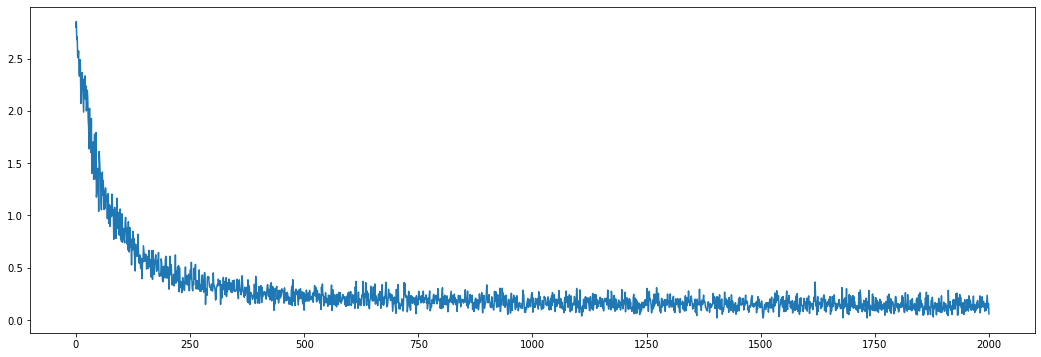

In [245]:
dnn = DNN_SVM(n_classes=4, units=[2, 50, 4], delta=1, learning_rate=0.001)
dnn.fit(X_train_2, y_train_2, batch_size=50, epochs=2001, show_result=True)

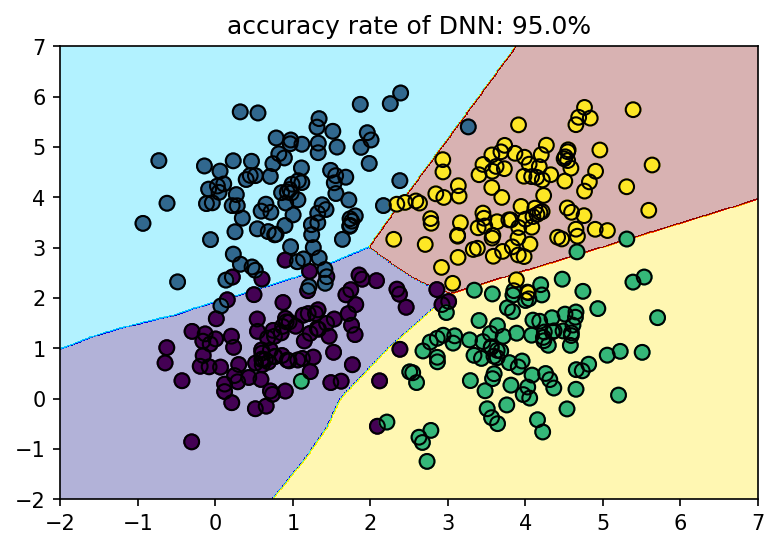

In [246]:
dnn.visualize([-2, 7], [-2, 7], dpi=150)

In [224]:
xv = np.random.rand(3, 5).T

xz = np.linalg.pinv(xv)

print(xz @ xv)

[[ 1.00000000e+00  1.35373250e-16 -4.83282550e-16]
 [ 2.56265167e-16  1.00000000e+00 -1.49113823e-16]
 [-5.12751080e-16 -3.85465167e-17  1.00000000e+00]]


In [211]:
# check gradient

w_hi = np.random.rand(16, 4)
x_hihi = np.random.rand(16, 5)
b_hihi = np.random.rand(4, 1)


In [212]:
z_hihi = w_hi.T @ x_hihi + b_hihi
t_Z_hi = ((z_hihi - b_hihi) @ np.linalg.pinv(x_hihi)).T
# print(w_hi)
# print(t_Z_hi)

def cost1(z):
  w = ((z - b_hihi) @ np.linalg.pinv(x_hihi)).T
  return np.sum(w * w)

def grad():
  return 2 * (w_hi.T @ np.linalg.pinv(x_hihi).T)

def numgr():
  eps = 1e-6
  fz = z_hihi.flatten()
  g = np.zeros_like(fz)
  for i in range(z_hihi.size):
    wp = fz.copy()
    wn = fz.copy()
    wp[i] += eps
    wn[i] -= eps
    g[i] = (cost1(wp.reshape(z_hihi.shape)) - cost1(wn.reshape(z_hihi.shape))) / (2 * eps)

  return g.reshape(z_hihi.shape)

g1 = grad()
g2 = numgr()
print(g1)
print(g2)
print('gradient different: ', np.linalg.norm(g1-g2))

[[ 0.54232096  0.62071494  0.32753512  0.54433765  0.18335647]
 [ 0.34515231 -0.60147088  0.74601967  0.59130277  0.93379267]
 [ 0.48496124  0.45634546 -0.01534662  0.21859073  0.53862288]
 [ 0.72519606 -0.55447917 -0.54382317  1.76585685  0.53591444]]
[[ 0.54232096  0.62071494  0.32753512  0.54433765  0.18335647]
 [ 0.34515231 -0.60147088  0.74601967  0.59130277  0.93379267]
 [ 0.48496124  0.45634546 -0.01534662  0.21859073  0.53862287]
 [ 0.72519606 -0.55447917 -0.54382317  1.76585685  0.53591444]]
gradient different:  4.924765174863605e-09
